In [1]:
#NOTE: we assume all time series data in PST time. Only time we are working with non PST data is when 
# we receive data and then convert. See get_occupancy function for how to do that.
# base imports
import time
from collections import defaultdict
%matplotlib inline
import pandas as pd
from copy import copy
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pytz
tz = pytz.timezone("US/Pacific")
import doctest
import matplotlib.lines as plt_line
import matplotlib
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
# for fetching data
from xbos import get_client
from xbos.services.pundat import DataClient, timestamp, make_dataframe, merge_dfs
from xbos.services.hod import HodClient

In [3]:
# get a bosswave client
c = get_client(entity="/Users/Daniel/CIEE/SetUp/ciee_readonly.ent", agent="127.0.0.1:28589")
# get a HodDB client
hod = HodClient("ciee/hod", c)
# get an archiver client
archiver = DataClient(c,archivers=["ucberkeley"])

Saw [ciee/hod] HodDB -1 hours 86379 seconds 479.88 ms ago
Saw [ucberkeley] archiver -1 hours 86375 seconds 212.586 ms ago


# Basic Fault Detection

In [4]:
def set_time_zone(data, whole_days=True):
    """Adjusts the given timezone from GMT to Pacific Time.
    Parameters:
            data: The time series data for which we want to make the time zone shift.
            whole_days: If true, then we want our timeseries data to start at the beginning of a day (00:00:00) and end at the end of a day (23:59:59). In 
                        the implementation we are assuming continious data. If the timeseries data starts at day x and ends at day y, then we expect the
                        time series data to included all days between x and y.
    Returns:
        A Pandas time-series Dataframe which has the index adjusted."""
    # next three lines do the time zone change
    idx = data.index
    idx = idx.tz_localize(pytz.utc).tz_convert(tz)
    data.index = idx
    if whole_days:
        #The following will make sure that we only have whole days in the returned DF, because of timezones.
        # Need to truncate ends since we don't have more data to pull from and we want whole days.
        if data.index[0].time() > pd.Timestamp("00:00:00").time():
            temp = data.index[0]
            d_temp = pd.Timestamp(temp + pd.Timedelta("1 days"))
            d_temp = d_temp.replace(hour=0,minute=0,second=0)
            data = data.loc[d_temp:]
        if data.index[-1].time() < pd.Timestamp("23:45:00").time():
            temp = data.index[-1]
            d_temp = pd.Timestamp(temp + pd.Timedelta("-1 days"))
            d_temp = d_temp.replace(hour=23,minute=45,second=0)
            data = data.loc[:d_temp]
    return data
        

def get_heating_temperature(start='"2017-09-01 00:00:00 MST"', end='"2017-09-12 00:00:00 MST"', time_steps="5T"):
    """Returns a dictionary {Zone: {Heating: pd.df, Temperature: pd.df}}. It is indexed as timeseries data with time_steps as given.
    It has all the data in the range of times start to end as given.
    Note, the data is given in MST time as that is how it stores. We will convert it in the function to PST.
    Parameters:
        start: When should the data start. Has to be a string of a string '"Time"'.
        end: when should the data end. Has to be a string of a string '"Time"'.
        time_steps: in what intervals (start, start+time+steps) do we want to look at data. 
    Returns:
       Only returns the data for whole days. Will truncate edge days if needed. The Temperature dataframe will
       have for each time a set of sensor temperature readings. The heating will have only one reading for the
       HVAC Zone.
         
    IMPROVEMENT TO ME: maybe make it such that we don't have to store the data in a different cell. such that
            we only ever have to make a call to this function, and it will somehow store the already pulled function, 
            such that it doesn't have to pull it over and over again.
            
    FIX to not make it truncuate. Could get extra days around edge. """
    
    
    zones = defaultdict(lambda: defaultdict(list))
    
    # define a Brick query and get the heating information
    heating_q = """SELECT ?x ?hvaczone ?uuid WHERE { 
    ?x bf:controls/bf:feeds ?hvaczone .
     ?hvaczone rdf:type brick:HVAC_Zone .
    ?x rdf:type/rdfs:subClassOf* brick:Thermostat .
      ?x bf:hasPoint ?status .
      ?status rdf:type brick:Thermostat_Status .
      ?status bf:uuid ?uuid .
    };
    """
    heating_uuid = hod.do_query(heating_q)['Rows']
    for thermo in heating_uuid:
        zones[thermo["?hvaczone"]]["Heating"].append(thermo["?uuid"])

    # define a Brick query and get the temperature information
    temperature_q = """SELECT ?x ?uuid ?hvaczone WHERE { 
    ?x bf:uuid ?uuid .
    ?x bf:isLocatedIn/bf:isPartOf ?hvaczone .
     ?hvaczone rdf:type brick:HVAC_Zone .
    ?x rdf:type/rdfs:subClassOf* brick:Temperature_Sensor .
    };"""
    temperature_uuid = hod.do_query(temperature_q)['Rows']
    temperature_zones = defaultdict(list)
    for thermo in temperature_uuid:
        zones[thermo['?hvaczone']]["Temperature"].append(thermo['?uuid'])
        
    zone_df = defaultdict(lambda: defaultdict())
    for zone, values in zones.items():
        print(zone)
        # If we don't have the data for a zone, then we will just skip it.
        # TODO reconsider this approach
        if values["Heating"] == [] or values["Temperature"] == []:
            continue
            
        t_get_data = time.time()
        
        # following two lines get data.
        heating_data = make_dataframe(archiver.data_uuids(values["Heating"], start, end, timeout=300))
        temperature_data = make_dataframe(archiver.data_uuids(values["Temperature"], start, end, timeout=300))
        print("getting data took:", time.time() - t_get_data)
        

        t_merge_data = time.time()
        # following lines resample the data and put it into dataframes from dictionaries.
        heating_data = merge_dfs(heating_data, resample=time_steps, do_max=True) #  Taking the max is justified by
                            # by the reasoning that we won't have cooling and heating in the same 15 min. We always want to choose an action, so if there is anything but no heating/cooling then choose that. Taking the maximum
            # could be an issue if we had cooling and heating at the same time, since we would take the higher numerical value, but assuming that it's either/or it's fine.
            #TODO. Average might mess up. Think of one-hot encoding. However, we want to know which state we were in on average.
        temperature_data = merge_dfs(temperature_data, resample=time_steps, do_mean=True) # Average temperature in time period.
        print("Took to merge: ", time.time() - t_merge_data)
        
        heating_data = set_time_zone(heating_data)
        temperature_data = set_time_zone(temperature_data)        
        
        zone_df[zone]["Heating"] = heating_data
        zone_df[zone]["Temperature"] = temperature_data
        return zone_df



    return zone_df

In [5]:
heating, temper = get_heating_temperature()

SouthZone
('getting data took:', 4.553551912307739)
('Took to merge: ', 1.0169758796691895)


ValueError: need more than 1 value to unpack

In [85]:
h = heating.values()[0].squeeze()
t = temper.values()[0].squeeze()
print(h[6350:])
print(t[6250:6300])
heating_data = set_time_zone(h)


time
2017-09-01 17:44:45.054715982    3.0
2017-09-01 17:44:55.091641089    3.0
2017-09-01 17:45:05.126317188    3.0
2017-09-01 17:45:15.160310510    3.0
2017-09-01 17:45:25.201180578    3.0
2017-09-01 17:45:35.230088820    3.0
2017-09-01 17:45:45.267787081    3.0
2017-09-01 17:45:55.303958269    3.0
2017-09-01 17:46:05.335396156    3.0
2017-09-01 17:46:15.520650138    3.0
2017-09-01 17:46:25.658079439    3.0
2017-09-01 17:46:35.759349406    3.0
2017-09-01 17:46:45.783969162    3.0
2017-09-01 17:46:55.822616151    3.0
2017-09-01 17:47:05.963485331    3.0
2017-09-01 17:47:16.096362874    3.0
2017-09-01 17:47:26.131312711    3.0
2017-09-01 17:47:36.376954272    2.0
2017-09-01 17:47:46.438963416    2.0
2017-09-01 17:47:56.556952761    2.0
2017-09-01 17:48:06.579408594    2.0
2017-09-01 17:48:16.613797101    2.0
2017-09-01 17:48:26.651050630    2.0
2017-09-01 17:48:36.684557372    2.0
2017-09-01 17:48:46.720230551    2.0
2017-09-01 17:48:56.745701088    2.0
2017-09-01 17:49:06.818626033    

In [6]:
data = get_heating_temperature()

SouthZone
('getting data took:', 4.621469020843506)
('Took to merge: ', 1.2460088729858398)


Want to see if we are heating but temperature is not increasing and not heating temperature increasing or vice versa. Could be a confusion matrix. look at the difference in temperature in the last 15 min always. 

In [7]:
def set_delta_temperature(temperature_data):
    """Takes time series temperature data and computes the increase from the i-1th reading to the ith read.
    Parameters:
            temperature_data: Time series temperature data. Should have a column called "Temperature" in which the
            temperature data is stored.
    Returns:
            A pandas DataFrame with the same index as temperature_data and a column "delta_Temperature" which 
            indicates the temperature increase. Very first element is zero, since we don't have data for before 
            the start."""
    x = temperature_data["Temperature"]['24f521b8-eef6-3ca8-9c71-59752b0ba45d_value']
    
    
    #.mean(axis=1, skipna=True) # takes rowwise average. Not very accurate but also saves us from one faulty thermostat.
    delta_temp = np.zeros(x.values.shape)
    delta_temp[1:] = x.values[1:] - x.values[:-1] # the ith item will be the temperature increase in the last time interval min. Beginning will be zero change, since we don't have endless data.
    delta_temp_df = pd.DataFrame(data=delta_temp, columns=["delta_Temperature"], index=x.index)
    return delta_temp_df

In [8]:
sz = set_delta_temperature(data["SouthZone"])


In [12]:
def temp_heating_or_not(delta_temerpature, threshold):
    # not heating nor cooling
    if abs(delta_temerpature) <= threshold:
        return 0
    # cooling down
    if delta_temerpature < -threshold:
        return 2
    # Heating
    if delta_temerpature > threshold:
        return 1

def temperature_indicating_heating(temperature_data, threshold=0.01):
    """Assumes temperature_data has column delta_Termperature
    """
    temp = pd.DataFrame(temperature_data["delta_Temperature"].map(lambda x: temp_heating_or_not(x, threshold)))
    temp.columns = ["Temperature_Indicator"]
    return temp

def confusion_heating_temperature(heating, temperature):
    """Threshold is for what we consider a state in which temperature is not changing."""
    heating = heating.squeeze() # makes a one column dataframe into Series
    temperature_indicator = temperature.squeeze()
    C = confusion_matrix(heating.values.astype(int), temperature_indicator.values.astype(int), labels=[0,1,2]) # rows are the values by heating and rows by temerpature_indicator
    return C
    

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.copper_r):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Heating')
    plt.xlabel('Temperaure_Indicator')
    plt.show

Confusion matrix, without normalization
[[1144  551  500]
 [   0    0    0]
 [  42   96  207]]


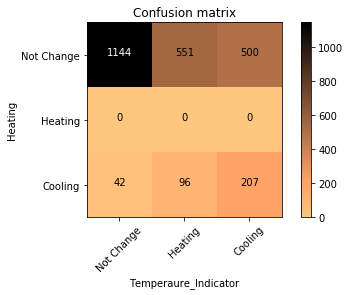

In [14]:
s = temperature_indicating_heating(sz)
south = data["SouthZone"]["Heating"]
c = confusion_heating_temperature(south, s)
plot_confusion_matrix(c, ["Not Change","Heating", "Cooling"])


In [ ]:
from scipy.optimize import curve_fit


# i think it learns which increase corresponds to heating or not.
def func(X, c1, c2, c3, c4):
    Tin, a1, a2 = X
    return c1 * a1 * Tin + c2 * a2 * Tin + c3 * Tin + c4

class ThermalModel:

    def __init__(self, df):

        self.df = df
        self.popt, pcov = curve_fit(func, df[['tin', 'a1' , 'a2']].T.as_matrix(), df['temp_next'].as_matrix())

    def next_temperature(self, Tin, action, now_time, zone=0):
        if action == 'Heating' or action == '2':
            return round(func([Tin, 1, 0], * self.popt) * 20) / 20.0
        elif action == 'Cooling' or action == '1':
            return round(func([Tin, 0, 1], *self.popt) * 20) / 20.0
        # elif action == 'Ventilation':
        # 	Heating, Cooling, Ventilation = 0, 0, 1
        else:
            return round(func([Tin, 0, 0], *self.popt) * 20) / 20.0